In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
customers = pd.read_csv("data/customers.csv")

In [4]:
# dropping customer fn and fn freq
customers = customers[["customer_id","age"]]

In [5]:
customers.dropna(subset=["age"],inplace=True)
print("Total customers after drop: ",customers.shape[0])
print("Customers with missing age",customers["age"].isna().sum())

Total customers after drop:  1356119
Customers with missing age 0


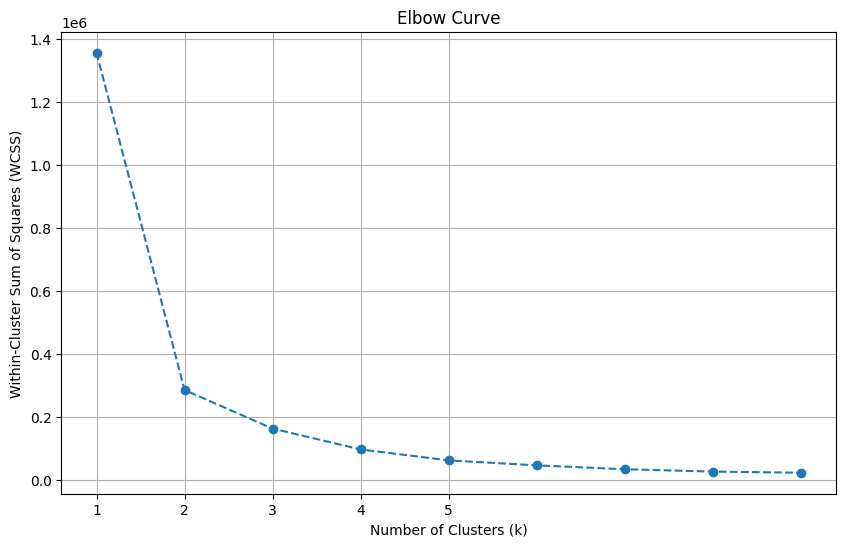

In [9]:
# Prepare the data
X = customers[['age']]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering with different values of k
wcss = []
for k in range(1, 10):  # Trying k values from 1 to 5
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(np.arange(1, 6, 1))
plt.grid(True)
plt.show()

In [11]:
# Based on the elbow curve, choose the optimal number of clusters
# Let's choose k=3 as the elbow point is at k=3

# Perform K-means clustering with k=3
kmeans = KMeans(n_clusters=4, random_state=42)
customers['cluster'] = kmeans.fit_predict(X_scaled)

# Print the cluster centers
print("Cluster Centers:")
print(scaler.inverse_transform(kmeans.cluster_centers_))

# Display the clustered customers DataFrame
print("\nClustered Customers:")
customers

Cluster Centers:
[[59.56582223]
 [31.17848297]
 [46.42478339]
 [22.23711723]]

Clustered Customers:


,customer_id,age,cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,2
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,3
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,3
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,2
...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,24.0,3
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,21.0,3
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,21.0,3
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,18.0,3


In [12]:
customers1 = customers[customers["cluster"]==0]
customers2 = customers[customers["cluster"]==1]
customers3 = customers[customers["cluster"]==2]
customers4 = customers[customers["cluster"]==3]

In [14]:
print(customers1.shape[0])
print(customers2.shape[0])
print(customers3.shape[0])
print(customers4.shape[0])

231396
353283
305624
465816


In [15]:
transactions = pd.read_csv("data/transactions_train.csv")

In [23]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

In [24]:
# Perform inner join on 'customer_id'
transactions1 = pd.merge(transactions, customers1, on='customer_id', how='inner')
transactions2 = pd.merge(transactions, customers2, on='customer_id', how='inner')
transactions3 = pd.merge(transactions, customers3, on='customer_id', how='inner')
transactions4 = pd.merge(transactions, customers4, on='customer_id', how='inner')

In [17]:
articles = pd.read_csv("data/articles.csv")

In [ ]:
from sklearn import preprocessing
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [38]:
def assoc_rules_func(articles, transactions, date='2020-08-12'):
    
    # association rule mining : method 2
    le = preprocessing.LabelEncoder()

    # concatenating 'perceived_colour_master_name' and 'product_type_name' attributes to 'item'
    articles_copy = articles 
    # print(articles_copy['perceived_colour_master_name'].nunique())
    # print(articles_copy['perceived_colour_master_name'].unique())
    # print(articles_copy['product_type_name'].nunique())
    # print(articles_copy['product_type_name'].unique())
    
    articles_copy = articles_copy[['article_id','perceived_colour_master_name','product_type_name']]
    articles_copy['item'] = articles_copy['perceived_colour_master_name'] + ['-'] + articles['product_type_name']
    # print(articles_copy.head())
    
    articles_copy = articles_copy[['article_id','item']]
    # print(articles_copy.head())
    # print(articles_copy.shape) 

    # merging 'item' attribute from articles in transactions
    last_month_transactions_copy = transactions.loc[transactions.t_dat >= pd.to_datetime(date)]
    last_month_transactions_copy = pd.merge(last_month_transactions_copy,articles_copy,how="left",on='article_id')
    # print(last_month_transactions_copy.head())
    # print(last_month_transactions_copy.shape)

    # converting into 1 hot encoding form 
    last_month_transactions_copy['customer_id'] = le.fit_transform(last_month_transactions_copy['customer_id'])
    # print(last_month_transactions_copy.head())
    # print(last_month_transactions_copy.shape) 

    last_month_transactions_copy['customer_id'] = last_month_transactions_copy['customer_id'].astype(str)
    # print(last_month_transactions_copy.head())
    # print(last_month_transactions_copy.shape)
    
    last_month_transactions_copy['item'].nunique()
    
    last_month_transactions_copy = last_month_transactions_copy[["t_dat","customer_id","item"]].groupby(['t_dat','customer_id'])['item'].unique().reset_index()
    # print(last_month_transactions_copy.head())
    # print(last_month_transactions_copy.shape)
    
    te = TransactionEncoder()
    
    te.fit(last_month_transactions_copy['item'])
    orders_1hot = te.transform(last_month_transactions_copy['item'])
    orders_1hot = pd.DataFrame(orders_1hot, columns =te.columns_)
    
    # print(orders_1hot.head())
    # print(orders_1hot.shape)

    # applying apriori to get frequent itemsets
    frequent_itemsets = apriori(orders_1hot, min_support=0.01, max_len=3, use_colnames=True)
    frequent_itemsets.sort_values(by=['support'], ascending=False)

    # print(frequent_itemsets.head())
    # print(frequent_itemsets.shape)
    frequent_itemsets['itemset_size'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    
    # print(frequent_itemsets['itemset_size'].describe())

    # getting association rules
    assoc_rules = association_rules(frequent_itemsets,metric='confidence', min_threshold=0.05)
    
    assoc_rules['antecedents_length'] = assoc_rules['antecedents'].apply(lambda x: len(x))
    assoc_rules['consequents_length'] = assoc_rules['consequents'].apply(lambda x: len(x))
    assoc_rules.sort_values(by='confidence',ascending=False).reset_index()

    return assoc_rules 

In [39]:
from sklearn import preprocessing
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [40]:
assoc_rules_func(articles, transactions1)

C:\Users\prabh\AppData\Local\Temp\ipykernel_35156\1764836501.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_copy['item'] = articles_copy['perceived_colour_master_name'] + ['-'] + articles['product_type_name']


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
0,(Black-Trousers),(Black-Sweater),0.120085,0.062607,0.010324,0.085975,1.373236,0.002806,1.025565,0.308886,1,1
1,(Black-Sweater),(Black-Trousers),0.062607,0.120085,0.010324,0.164904,1.373236,0.002806,1.053670,0.289946,1,1
2,(Black-Trousers),(Blue-Trousers),0.120085,0.087979,0.020088,0.167285,1.901424,0.009523,1.095238,0.538777,1,1
3,(Blue-Trousers),(Black-Trousers),0.087979,0.120085,0.020088,0.228332,1.901424,0.009523,1.140277,0.519811,1,1
4,(Black-Trousers),(Grey-Trousers),0.120085,0.040877,0.010515,0.087565,2.142164,0.005607,1.051169,0.605947,1,1
5,(Grey-Trousers),(Black-Trousers),0.040877,0.120085,0.010515,0.257241,2.142164,0.005607,1.184658,0.555906,1,1


In [41]:
assoc_rules_func(articles, transactions2)

C:\Users\prabh\AppData\Local\Temp\ipykernel_35156\1764836501.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_copy['item'] = articles_copy['perceived_colour_master_name'] + ['-'] + articles['product_type_name']


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
0,(Black-Bra),(Black-Underwear bottom),0.045228,0.050377,0.010755,0.237802,4.720398,0.008477,1.245900,0.825489,1,1
1,(Black-Underwear bottom),(Black-Bra),0.050377,0.045228,0.010755,0.213495,4.720398,0.008477,1.213943,0.829965,1,1
2,(Black-Trousers),(Black-Dress),0.117953,0.090944,0.012490,0.105889,1.164323,0.001763,1.016714,0.160005,1,1
3,(Black-Dress),(Black-Trousers),0.090944,0.117953,0.012490,0.137335,1.164323,0.001763,1.022468,0.155251,1,1
4,(Black-Leggings/Tights),(Black-Top),0.069937,0.070572,0.012103,0.173051,2.452131,0.007167,1.123925,0.636722,1,1
5,(Black-Top),(Black-Leggings/Tights),0.070572,0.069937,0.012103,0.171494,2.452131,0.007167,1.122579,0.637157,1,1
6,(Black-Trousers),(Black-Leggings/Tights),0.117953,0.069937,0.010275,0.087114,1.245602,0.002026,1.018816,0.223543,1,1
7,(Black-Leggings/Tights),(Black-Trousers),0.069937,0.117953,0.010275,0.146922,1.245602,0.002026,1.033959,0.212002,1,1
8,(Black-Trousers),(Black-Sweater),0.117953,0.063696,0.012800,0.108514,1.703634,0.005286,1.050274,0.468251,1,1
9,(Black-Sweater),(Black-Trousers),0.063696,0.117953,0.012800,0.200948,1.703634,0.005286,1.103868,0.441117,1,1


In [42]:
assoc_rules_func(articles, transactions3)

C:\Users\prabh\AppData\Local\Temp\ipykernel_35156\1764836501.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_copy['item'] = articles_copy['perceived_colour_master_name'] + ['-'] + articles['product_type_name']


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
0,(Black-Trousers),(Black-Sweater),0.136269,0.072961,0.014753,0.108264,1.483861,0.004811,1.039589,0.377528,1,1
1,(Black-Sweater),(Black-Trousers),0.072961,0.136269,0.014753,0.202205,1.483861,0.004811,1.082647,0.351746,1,1
2,(Blue-Trousers),(Black-Sweater),0.121337,0.072961,0.010476,0.086336,1.183318,0.001623,1.014639,0.176312,1,1
3,(Black-Sweater),(Blue-Trousers),0.072961,0.121337,0.010476,0.143580,1.183318,0.001623,1.025972,0.167111,1,1
4,(Black-Trousers),(Black-Top),0.136269,0.068324,0.011649,0.085486,1.251188,0.002339,1.018766,0.232433,1,1
5,(Black-Top),(Black-Trousers),0.068324,0.136269,0.011649,0.170499,1.251188,0.002339,1.041265,0.215482,1,1
6,(Black-Trousers),(Blue-Trousers),0.136269,0.121337,0.033272,0.244167,2.012309,0.016738,1.162509,0.582425,1,1
7,(Blue-Trousers),(Black-Trousers),0.121337,0.136269,0.033272,0.274216,2.012309,0.016738,1.190066,0.572527,1,1
8,(Black-Trousers),(Grey-Trousers),0.136269,0.053675,0.016258,0.119306,2.222739,0.008943,1.074521,0.636894,1,1
9,(Grey-Trousers),(Black-Trousers),0.053675,0.136269,0.016258,0.302891,2.222739,0.008943,1.239019,0.581306,1,1


In [43]:
assoc_rules_func(articles, transactions4)

C:\Users\prabh\AppData\Local\Temp\ipykernel_35156\1764836501.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_copy['item'] = articles_copy['perceived_colour_master_name'] + ['-'] + articles['product_type_name']


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
0,(Black-Leggings/Tights),(Black-Top),0.049739,0.067823,0.010517,0.211436,3.117439,0.007143,1.182118,0.714776,1,1
1,(Black-Top),(Black-Leggings/Tights),0.067823,0.049739,0.010517,0.155060,3.117439,0.007143,1.124648,0.728643,1,1
2,(Black-Trousers),(Black-Sweater),0.111847,0.068195,0.012014,0.107410,1.575046,0.004386,1.043934,0.411076,1,1
3,(Black-Sweater),(Black-Trousers),0.068195,0.111847,0.012014,0.176165,1.575046,0.004386,1.078071,0.391818,1,1
4,(White-Sweater),(Black-Sweater),0.057673,0.068195,0.011265,0.195328,2.864264,0.007332,1.157994,0.690705,1,1
5,(Black-Sweater),(White-Sweater),0.068195,0.057673,0.011265,0.165190,2.864264,0.007332,1.128792,0.698505,1,1
6,(Black-Trousers),(Blue-Trousers),0.111847,0.106691,0.024787,0.221611,2.077120,0.012853,1.147638,0.583868,1,1
7,(Blue-Trousers),(Black-Trousers),0.106691,0.111847,0.024787,0.232320,2.077120,0.012853,1.156931,0.580498,1,1
8,(Black-Trousers),(Grey-Trousers),0.111847,0.038064,0.010217,0.091351,2.399918,0.005960,1.058644,0.656778,1,1
9,(Grey-Trousers),(Black-Trousers),0.038064,0.111847,0.010217,0.268424,2.399918,0.005960,1.214027,0.606401,1,1


In [48]:
def assoc_rules_func2(articles, transactions, date='2020-08-12'):
    
    # association rule mining : method 2
    le = preprocessing.LabelEncoder()

    # concatenating 'perceived_colour_master_name' and 'product_type_name' attributes to 'item'
    articles_copy = articles 
    # print(articles_copy['perceived_colour_master_name'].nunique())
    # print(articles_copy['perceived_colour_master_name'].unique())
    # print(articles_copy['product_type_name'].nunique())
    # print(articles_copy['product_type_name'].unique())
    
    articles_copy = articles_copy[['article_id','perceived_colour_master_name','product_type_name','prod_name']]
    articles_copy['item'] = articles_copy['perceived_colour_master_name'] + ['-'] + articles['prod_name']
    # print(articles_copy.head())
    
    articles_copy = articles_copy[['article_id','item']]
    # print(articles_copy.head())
    # print(articles_copy.shape) 

    # merging 'item' attribute from articles in transactions
    last_month_transactions_copy = transactions.loc[transactions.t_dat >= pd.to_datetime(date)]
    last_month_transactions_copy = pd.merge(last_month_transactions_copy,articles_copy,how="left",on='article_id')
    # print(last_month_transactions_copy.head())
    # print(last_month_transactions_copy.shape)

    # converting into 1 hot encoding form 
    last_month_transactions_copy['customer_id'] = le.fit_transform(last_month_transactions_copy['customer_id'])
    # print(last_month_transactions_copy.head())
    # print(last_month_transactions_copy.shape) 

    last_month_transactions_copy['customer_id'] = last_month_transactions_copy['customer_id'].astype(str)
    # print(last_month_transactions_copy.head())
    # print(last_month_transactions_copy.shape)
    
    last_month_transactions_copy['item'].nunique()
    
    last_month_transactions_copy = last_month_transactions_copy[["t_dat","customer_id","item"]].groupby(['t_dat','customer_id'])['item'].unique().reset_index()
    # print(last_month_transactions_copy.head())
    # print(last_month_transactions_copy.shape)
    
    te = TransactionEncoder()
    
    te.fit(last_month_transactions_copy['item'])
    orders_1hot = te.transform(last_month_transactions_copy['item'])
    orders_1hot = pd.DataFrame(orders_1hot, columns =te.columns_)
    
    # print(orders_1hot.head())
    # print(orders_1hot.shape)

    # applying apriori to get frequent itemsets
    frequent_itemsets = apriori(orders_1hot, min_support=0.01, max_len=3, use_colnames=True)
    frequent_itemsets.sort_values(by=['support'], ascending=False)

    # print(frequent_itemsets.head())
    # print(frequent_itemsets.shape)
    frequent_itemsets['itemset_size'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    
    # print(frequent_itemsets['itemset_size'].describe())

    # getting association rules
    assoc_rules = association_rules(frequent_itemsets,metric='confidence', min_threshold=0.05)
    
    assoc_rules['antecedents_length'] = assoc_rules['antecedents'].apply(lambda x: len(x))
    assoc_rules['consequents_length'] = assoc_rules['consequents'].apply(lambda x: len(x))
    assoc_rules.sort_values(by='confidence',ascending=False).reset_index()

    return assoc_rules 

In [49]:
assoc_rules_func2(articles, transactions1)

C:\Users\prabh\AppData\Local\Temp\ipykernel_35156\471714052.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_copy['item'] = articles_copy['perceived_colour_master_name'] + ['-'] + articles['prod_name']


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
